<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-10/LR_with_propensity_compare_SIP_and_no_SIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. load data

In [ ]:
#cd drive/My\ Drive/fall

[Errno 2] No such file or directory: 'drive/My Drive/fall'
/content/drive/My Drive/fall


In [2]:
ls

county_data_with_reduced_covariates_with_SIP.csv  sample_data/
covid19_before_0601_2020.csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [5]:
data.dropna(inplace = True)

In [6]:
print(f"after dropping this dataset has {data.shape[0]} records.")

after dropping this dataset has 2995 records.


In [8]:
data.head(10)

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9
5,1.0,AL,Alabama,Bullock County,1011.0,-0.009576,1,29267.0,51.4,10138,0.508615,21.1,16.4,0.2,69.5,8.0,21.2
6,1.0,AL,Alabama,Butler County,1013.0,0.015350,1,37365.0,71.2,19680,-0.135291,22.2,20.3,1.3,44.6,1.5,51.3
7,1.0,AL,Alabama,Calhoun County,1015.0,0.017585,1,45400.0,33.7,114277,-0.413838,21.6,17.7,1.0,20.9,3.9,72.0
8,1.0,AL,Alabama,Chambers County,1017.0,0.002033,1,39917.0,49.1,33615,-0.148062,20.8,19.5,1.3,39.6,2.6,55.2
9,1.0,AL,Alabama,Cherokee County,1019.0,0.004307,1,42132.0,85.7,26032,-0.693611,19.2,23.0,0.3,4.2,1.6,91.7


In [22]:
covid19_data = pd.read_csv('covid19_before_0601_2020.csv')
data = data.merge(covid19_data[['fips', 'daily_cases_max', 'daily_cases_mean']], left_on='county_code', right_on='fips')

# 1. PSM

In [14]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [15]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")
# load MatchIt package
library(MatchIt)
# install optimal match package
install.packages('optmatch')
library(optmatch)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘RcppProgress’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/RcppProgress_0.4.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 12077 bytes (11 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [23]:
# rename data to dataframe
dataframe = data

In [25]:
# -i means pass in some argument/data from python world to R world
%%R -i dataframe

# using MatchIt package to do PSM - guess it used logistic regression?

m.out <- matchit(SIP.~Median.Household.Income + X..Rural +
                 political_diff+
                 X..Asian + X..Black + 
                 X..Non.Hispanic.White +
                 X..Hispanic + Population_y + daily_cases_mean,
                 method = "full", data = dataframe) 

R[write to console]: Warning:
R[write to console]:  Fewer control units than treated units; some control units will be matched to multiple treated units.



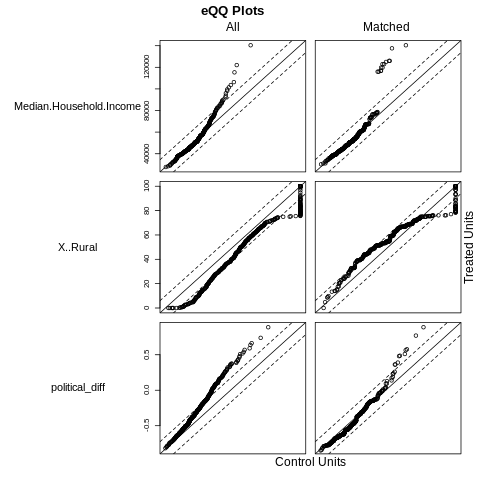

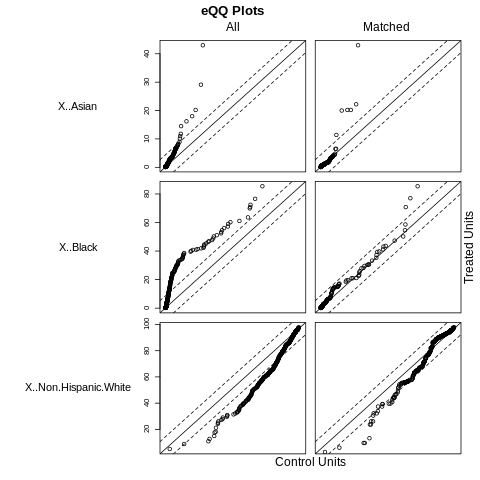

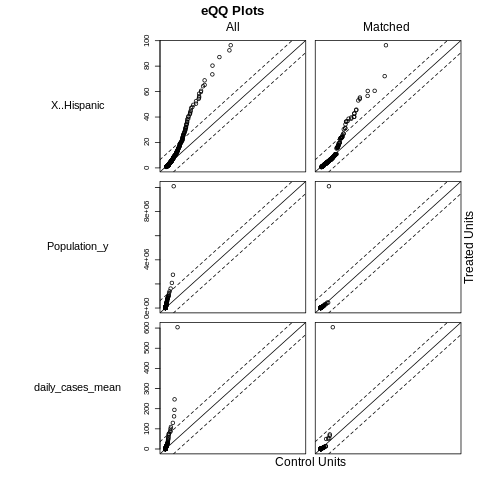

In [58]:
# to see how maching it doing by visualizing distributions
%%R
plot(m.out)

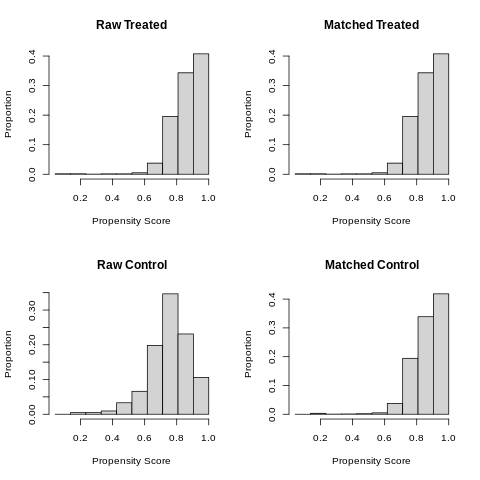

In [59]:
%%R
plot(m.out, type = 'hist')

[1] "To identify the units, use first mouse button; to stop, use second."
integer(0)


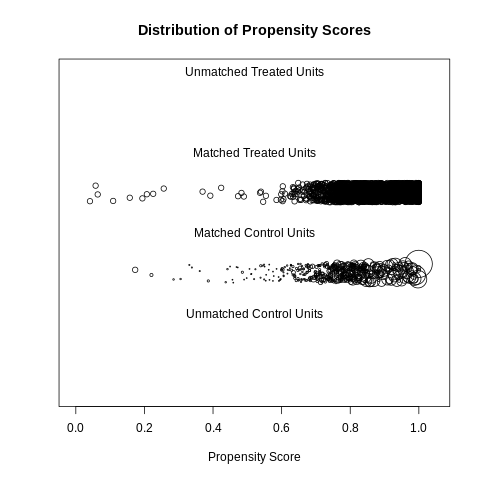

In [28]:
%%R
plot(m.out, type='jitter')

In [29]:
%%R
summary(m.out, standardize=T)


Call:
matchit(formula = SIP. ~ Median.Household.Income + X..Rural + 
    political_diff + X..Asian + X..Black + X..Non.Hispanic.White + 
    X..Hispanic + Population_y + daily_cases_mean, data = dataframe, 
    method = "full")

Summary of Balance for All Data:
                        Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                       0.8710        0.7533          1.1468     0.6348
Median.Household.Income    53134.1357    53065.9929          0.0047     1.9132
X..Rural                      54.5805       62.8969         -0.2706     1.1482
political_diff                -0.2828       -0.4201          0.4419     2.0233
X..Asian                       1.6900        1.0179          0.2262     5.2413
X..Black                      10.4841        4.1578          0.4183     2.6117
X..Non.Hispanic.White         74.7180       82.2120         -0.3669     2.0373
X..Hispanic                   10.2024        6.5906          0.2469     5.4064
Population_y              

In [30]:
%%R
# extract matched data.
matched_data <- match.data(m.out)

In [31]:
# import dataframe from R to python.... since I am not familar with manipulating
# R objects 
matched_data = %R matched_data

In [32]:
no_SIP_diff = np.average(matched_data[matched_data['SIP.'] == 0]['diff_in_perc_at_home'], weights = matched_data[matched_data['SIP.'] == 0]['weights'])

In [33]:
SIP_diff = np.average(matched_data[matched_data['SIP.'] == 1]['diff_in_perc_at_home'], weights = matched_data[matched_data['SIP.'] == 1]['weights'])

In [34]:
SIP_diff

0.03370005271412831

In [35]:
no_SIP_diff

0.021599414195746677

In [36]:
SIP_diff - no_SIP_diff

0.012100638518381637

In [37]:
matched_data

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,distance,weights,subclass
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,21.0,3.231884,0.840300,1.000000,1
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,12.0,3.670886,0.972917,1.000000,124
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,17.0,2.813559,0.972368,1.000000,124
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,7.0,1.206349,0.861901,1.000000,80
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,5.0,0.897059,0.859750,1.000000,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,4.0,0.434783,0.671294,0.171244,21
2896,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,20.0,1.413333,0.799737,1.000000,355
2897,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,2.0,0.233333,0.659457,0.085622,143
2898,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,10.0,0.530303,0.663896,0.171244,215


Seems like distance column is the propensity score we want because you can find out [here](https://cran.r-project.org/web/packages/MatchIt/MatchIt.pdf) that without specifying any distance metric the default distance is "logit", which I think is the propensity score we are using.

In [38]:
# max propensity score
matched_data['distance'].max()

0.9999999999999998

In [39]:
matched_data[matched_data['distance'] == matched_data['distance'].max()]

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,distance,weights,subclass
88,4.0,AZ,Arizona,Maricopa County,4013.0,0.070350,1,65234.0,2.4,4410824,-0.034465,23.9,15.2,4.6,5.5,31.3,54.9,4013.0,410.0,77.275591,1.0,1.0,97
187,6.0,CA,California,Los Angeles County,6037.0,0.118096,1,67986.0,0.6,10105518,0.480185,21.7,13.6,15.4,8.0,48.6,26.1,6037.0,2089.0,433.031496,1.0,1.0,97
197,6.0,CA,California,Orange County,6059.0,0.159275,1,89373.0,0.1,3185968,0.076800,21.9,14.8,21.4,1.6,34.2,40.1,6059.0,198.0,49.632812,1.0,1.0,97
200,6.0,CA,California,Riverside County,6065.0,0.091735,1,66793.0,4.6,2450758,0.043345,25.1,14.4,7.1,6.2,49.6,34.7,6065.0,540.0,87.104651,1.0,1.0,97
203,6.0,CA,California,San Bernardino County,6071.0,0.065186,1,63310.0,4.7,2171603,0.097790,26.4,11.6,7.8,8.1,54.0,27.9,6071.0,273.0,67.243590,1.0,1.0,97
204,6.0,CA,California,San Diego County,6073.0,0.128628,1,78777.0,3.3,3343364,0.178358,21.6,14.0,12.6,4.7,34.0,45.2,6073.0,237.0,67.348214,1.0,1.0,97
335,12.0,FL,Florida,Miami-Dade County,12086.0,0.156587,1,52043.0,0.4,2761581,0.295646,20.2,16.2,1.7,15.6,69.1,13.0,12086.0,526.0,219.487805,1.0,1.0,97
569,17.0,IL,Illinois,Cook County,17031.0,0.123588,1,63347.0,0.0,5180493,0.529565,21.8,14.6,7.9,23.0,25.5,42.1,17031.0,2155.0,604.062016,1.0,1.0,97
1613,32.0,NV,Nevada,Clark County,32003.0,0.097412,1,57155.0,1.3,2231647,0.106473,23.2,14.7,10.4,11.7,31.4,42.2,32003.0,233.0,75.636364,1.0,1.0,97
2335,48.0,TX,Texas,Bexar County,48029.0,0.082618,1,54210.0,4.5,1986049,0.134855,25.6,12.1,3.3,7.4,60.5,27.4,48029.0,189.0,25.827273,1.0,1.0,97


In [40]:
# minimum propensity score
matched_data['distance'].min()

0.041216718208284014

In [41]:
matched_data[matched_data['distance'] == matched_data['distance'].min()]

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,distance,weights,subclass
77,2.0,AK,Alaska,Northwest Arctic Borough,2188.0,0.063479,1,59337.0,57.5,7671,-0.151711,35.3,7.3,0.8,1.1,3.8,10.9,2188.0,1.0,0.083333,0.041217,1.0,187


# 2. standardize data for both data_SIP and data_no_SIP

In [42]:
# import packages from LR and standardize tool
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [43]:
# get only numeric columns because we can't scale the strings, etc.
matched_data = matched_data._get_numeric_data()

In [44]:
data_SIP = matched_data[matched_data['SIP.'] == 1]
data_no_SIP = matched_data[matched_data['SIP.'] == 0]

In [45]:
data_SIP

,state,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,distance,weights
0,1.0,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,21.0,3.231884,0.840300,1.0
1,1.0,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,12.0,3.670886,0.972917,1.0
2,1.0,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,17.0,2.813559,0.972368,1.0
3,1.0,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,7.0,1.206349,0.861901,1.0
4,1.0,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,5.0,0.897059,0.859750,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,55.0,55135.0,0.018980,1,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1,55135.0,10.0,0.606061,0.843908,1.0
2875,55.0,55137.0,-0.019303,1,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6,55137.0,2.0,0.125000,0.867437,1.0
2876,55.0,55139.0,0.071851,1,57785.0,13.4,171020,-0.074431,20.5,16.4,3.0,2.2,4.2,88.4,55139.0,19.0,3.088608,0.955198,1.0
2877,55.0,55141.0,0.007077,1,55879.0,36.7,73055,-0.192777,21.6,20.6,2.0,0.9,3.1,92.2,55141.0,2.0,0.116883,0.867869,1.0


In [46]:
data_no_SIP

,state,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,distance,weights
96,5.0,5001.0,0.002032,0,43887.0,34.7,17769,-0.305821,22.9,19.6,0.8,24.5,3.3,69.5,5001.0,1.0,0.109375,0.866155,2.226171
97,5.0,5003.0,0.004202,0,41127.0,51.7,20046,-0.365018,22.9,20.4,0.3,24.5,5.5,68.3,5003.0,3.0,0.296875,0.897535,4.794830
98,5.0,5005.0,-0.000820,0,39686.0,65.8,41619,-0.536072,17.7,30.9,0.5,0.4,2.5,94.5,5005.0,2.0,0.181818,0.830647,0.342488
99,5.0,5007.0,0.075433,0,68978.0,25.2,272608,-0.348571,26.3,13.4,4.1,1.8,16.9,73.0,5007.0,89.0,7.932432,0.985591,2.397415
100,5.0,5009.0,-0.000736,0,44482.0,62.2,37480,-0.584465,22.9,20.7,0.7,0.4,2.6,93.6,5009.0,1.0,0.094595,0.787536,0.171244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,56.0,56035.0,0.042121,0,74570.0,100.0,9813,-0.643472,22.5,19.5,0.7,0.8,7.5,89.0,56035.0,1.0,0.030769,0.719161,0.342488
2895,56.0,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,4.0,0.434783,0.671294,0.171244
2897,56.0,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,2.0,0.233333,0.659457,0.085622
2898,56.0,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,10.0,0.530303,0.663896,0.171244


Notice that we have state and county_code, which are not our covariates. I include them here to see the random covariate's coefficients in linear model

In [47]:
# function that given a dataframe, standardize its columns except the response
# column and the propensity score column and SIP. column.
def getScaledDataFrame(originalDataFrame):
  scaler = StandardScaler()
  # I here choose not to standardize all variables except
  # the response variable and propensity score
  X = originalDataFrame.drop(['distance', 'diff_in_perc_at_home', 'SIP.'], axis = 1)
  data_scaled = scaler.fit_transform(X)

  df_scaled = pd.DataFrame(data = data_scaled, columns = X.columns)
  df_others = originalDataFrame[['distance', 'diff_in_perc_at_home', 'SIP.']]
  df_others = df_others.reset_index() # make indices have the same type
  df_scaled['distance'] = df_others['distance']
  df_scaled['diff_in_perc_at_home'] = df_others['diff_in_perc_at_home']
  df_scaled['SIP.'] = df_others['SIP.']
  return df_scaled

In [48]:
df_SIP_scaled = getScaledDataFrame(data_SIP)
df_no_SIP_scaled = getScaledDataFrame(data_no_SIP)

In [49]:
df_SIP_scaled

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,weights,distance,diff_in_perc_at_home,SIP.
0,-1.930087,-1.934108,0.424108,-0.409435,-0.185728,-0.682184,0.564356,-0.727963,-0.164979,0.583023,-0.492503,-0.020472,-1.934108,-0.132625,-0.138898,0.0,0.840300,0.050678,1
1,-1.930087,-1.933977,0.304475,-0.399671,0.260905,-0.949456,-0.079639,0.344690,-0.164979,-0.111377,-0.383095,0.410496,-1.933977,-0.199719,-0.124290,0.0,0.972917,0.050312,1
2,-1.930087,-1.933846,-1.281933,0.430231,-0.270203,0.729192,-0.294304,0.121220,-0.400652,2.481052,-0.403609,-1.426012,-1.933846,-0.162445,-0.152818,0.0,0.972368,0.007037,1
3,-1.930087,-1.933715,-0.483328,0.449759,-0.277026,-0.877322,-0.416969,-0.526841,-0.501654,0.702064,-0.519855,-0.005780,-1.933715,-0.236994,-0.206298,0.0,0.861901,0.011809,1
4,-1.930087,-1.933583,-0.186091,1.152735,-0.179571,-1.708614,0.411024,-0.146943,-0.467987,-0.594151,-0.041194,0.596595,-1.933583,-0.251903,-0.216590,0.0,0.859750,0.038890,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1.619477,1.618680,0.376939,0.335850,-0.198028,-0.063394,-0.478302,0.456425,-0.366984,-0.660284,-0.471989,0.949204,1.618680,-0.214629,-0.226273,0.0,0.843908,0.018980,1
2472,1.619477,1.618811,-0.054289,1.136462,-0.271903,-0.130446,-1.091630,1.238568,-0.366984,-0.561084,-0.266848,0.728823,1.618811,-0.274268,-0.242280,0.0,0.867437,-0.019303,1
2473,1.619477,1.618943,0.317942,-1.340227,0.131657,0.670254,-0.416969,-0.549188,0.441036,-0.547857,-0.410447,0.670055,1.618943,-0.147535,-0.143665,0.0,0.955198,0.071851,1
2474,1.619477,1.619074,0.187644,-0.581924,-0.137732,0.289494,-0.079639,0.389384,0.104361,-0.633831,-0.485665,0.856155,1.619074,-0.274268,-0.242551,0.0,0.867869,0.007077,1


In [50]:
df_no_SIP_scaled

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,weights,distance,diff_in_perc_at_home,SIP.
0,-1.582406,-1.588661,-0.868779,-0.984295,-0.234575,0.523597,-0.225105,0.079459,-0.168137,2.176253,-0.523697,-0.889459,-1.588661,-0.358777,-0.318982,0.634426,0.866155,0.002032,0
1,-1.582406,-1.588530,-1.130009,-0.390861,-0.198061,0.252421,-0.225105,0.283028,-0.553905,2.176253,-0.173565,-0.973423,-1.588530,-0.307652,-0.284688,1.963462,0.897535,0.004202,0
2,-1.582406,-1.588400,-1.266398,0.101340,0.147884,-0.531163,-1.887234,2.954865,-0.399598,-0.402016,-0.651017,0.859788,-1.588400,-0.333215,-0.305732,-0.340200,0.830647,-0.000820,0
3,-1.582406,-1.588269,1.506049,-1.315920,3.852033,0.327764,0.861672,-1.498198,2.377933,-0.252241,1.640756,-0.644565,-1.588269,1.890709,1.111863,0.723029,0.985591,0.075433,0
4,-1.582406,-1.588138,-0.812463,-0.024328,0.081511,-0.752846,-0.225105,0.359366,-0.245290,-0.402016,-0.635102,0.796815,-1.588138,-0.358777,-0.321686,-0.428802,0.787536,-0.000736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,1.750402,1.749031,2.035325,1.295190,-0.362158,-1.023155,-0.352961,0.054013,-0.245290,-0.359223,0.144737,0.474954,1.749031,-0.358777,-0.333359,-0.340200,0.719161,0.042121,0
420,1.750402,1.749162,1.916541,-1.815103,0.170848,-0.528003,0.829708,-1.828996,-0.013829,-0.327128,1.513435,-0.203754,1.749162,-0.282090,-0.259465,-0.428802,0.671294,-0.018485,0
421,1.750402,1.749423,0.978194,-0.691069,-0.194004,-0.892388,1.660772,-1.320075,-0.399598,-0.369921,0.415294,0.363002,1.749423,-0.333215,-0.296310,-0.473103,0.659457,0.010157,0
422,1.750402,1.749554,0.201034,-0.938915,-0.393075,-1.008976,-0.289033,0.613826,-0.168137,-0.391317,1.195133,0.013152,1.749554,-0.128716,-0.241994,-0.428802,0.663896,-0.007825,0


# 3. create bins of propensity scores

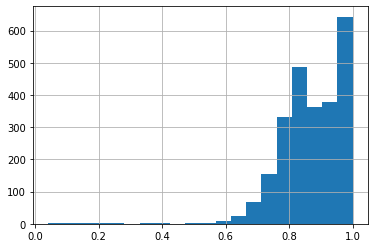

In [51]:
df_SIP_scaled['distance'].hist(bins = 20)

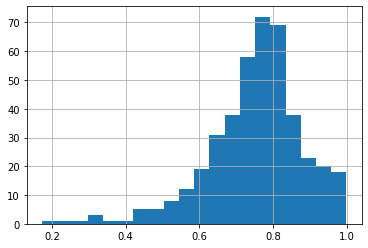

In [52]:
df_no_SIP_scaled['distance'].hist(bins = 20)

In [53]:
# we decided to cup propensity into 3 non-uniform groups to balance
# the number of data points in each group.
bins = pd.IntervalIndex.from_tuples([(0, 0.75), (0.75, 0.85), (0.85, 1)])
# create propensity buckets for df_SIP_scaled
propensity_buckets = pd.cut(df_SIP_scaled['distance'], bins)
df_SIP_scaled['propensity_bucket'] = propensity_buckets

# create propensity buckets for df_SIP_scaled
propensity_buckets = pd.cut(df_no_SIP_scaled['distance'], bins)
df_no_SIP_scaled['propensity_bucket'] = propensity_buckets

In [54]:
df_SIP_scaled.head()

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,weights,distance,diff_in_perc_at_home,SIP.,propensity_bucket
0,-1.930087,-1.934108,0.424108,-0.409435,-0.185728,-0.682184,0.564356,-0.727963,-0.164979,0.583023,-0.492503,-0.020472,-1.934108,-0.132625,-0.138898,0.0,0.840300,0.050678,1,"(0.75, 0.85]"
1,-1.930087,-1.933977,0.304475,-0.399671,0.260905,-0.949456,-0.079639,0.344690,-0.164979,-0.111377,-0.383095,0.410496,-1.933977,-0.199719,-0.124290,0.0,0.972917,0.050312,1,"(0.85, 1.0]"
2,-1.930087,-1.933846,-1.281933,0.430231,-0.270203,0.729192,-0.294304,0.121220,-0.400652,2.481052,-0.403609,-1.426012,-1.933846,-0.162445,-0.152818,0.0,0.972368,0.007037,1,"(0.85, 1.0]"
3,-1.930087,-1.933715,-0.483328,0.449759,-0.277026,-0.877322,-0.416969,-0.526841,-0.501654,0.702064,-0.519855,-0.005780,-1.933715,-0.236994,-0.206298,0.0,0.861901,0.011809,1,"(0.85, 1.0]"
4,-1.930087,-1.933583,-0.186091,1.152735,-0.179571,-1.708614,0.411024,-0.146943,-0.467987,-0.594151,-0.041194,0.596595,-1.933583,-0.251903,-0.216590,0.0,0.859750,0.038890,1,"(0.85, 1.0]"


In [55]:
df_no_SIP_scaled.head()

,state,county_code,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,fips,daily_cases_max,daily_cases_mean,weights,distance,diff_in_perc_at_home,SIP.,propensity_bucket
0,-1.582406,-1.588661,-0.868779,-0.984295,-0.234575,0.523597,-0.225105,0.079459,-0.168137,2.176253,-0.523697,-0.889459,-1.588661,-0.358777,-0.318982,0.634426,0.866155,0.002032,0,"(0.85, 1.0]"
1,-1.582406,-1.588530,-1.130009,-0.390861,-0.198061,0.252421,-0.225105,0.283028,-0.553905,2.176253,-0.173565,-0.973423,-1.588530,-0.307652,-0.284688,1.963462,0.897535,0.004202,0,"(0.85, 1.0]"
2,-1.582406,-1.588400,-1.266398,0.101340,0.147884,-0.531163,-1.887234,2.954865,-0.399598,-0.402016,-0.651017,0.859788,-1.588400,-0.333215,-0.305732,-0.340200,0.830647,-0.000820,0,"(0.75, 0.85]"
3,-1.582406,-1.588269,1.506049,-1.315920,3.852033,0.327764,0.861672,-1.498198,2.377933,-0.252241,1.640756,-0.644565,-1.588269,1.890709,1.111863,0.723029,0.985591,0.075433,0,"(0.85, 1.0]"
4,-1.582406,-1.588138,-0.812463,-0.024328,0.081511,-0.752846,-0.225105,0.359366,-0.245290,-0.402016,-0.635102,0.796815,-1.588138,-0.358777,-0.321686,-0.428802,0.787536,-0.000736,0,"(0.75, 0.85]"


# 4. linear regression in each bucket for both df_SIP and df_no_SIP

In [56]:
# given a dataframe, print out results of the linear regression
# on each propensity buckets. Assume such propensity bucket
# exists as a column of the dataframe
def linearRegressionOnBuckets(df_scaled):
  regressor = LinearRegression()
  # if this dataframe's column of SIP. includes 1, means it it dataframe with shelter in place.
  if 1 in df_scaled['SIP.'].unique():
    print('results for shelter in place counties:')
  else:
    print('results for counties without shelter in place')
  print()
  for bin in sorted(df_scaled['propensity_bucket'].unique()):
    data_in_this_bin = df_scaled[df_scaled['propensity_bucket'] == bin]
    X = data_in_this_bin.drop(['diff_in_perc_at_home', 'weights', 
                              'distance', 'propensity_bucket', 'county_code', 'state', 'SIP.'], axis = 1)
    y = data_in_this_bin['diff_in_perc_at_home']
    num_of_data_points = data_in_this_bin.shape[0]
    print(f'propensity score from {bin.left} to {bin.right} has {num_of_data_points} data points')
    regressor.fit(X, y)
    # argsort so we can see the most important coefficient of linear regression first
    for i in np.argsort(regressor.coef_)[::-1]:
      coef = regressor.coef_[i]
      print(f'after standardization, feature {X.columns[i]}\' coefficient is {coef} in this bucket')
    
    # print the average effect size for this bin.
    effect_size = np.average(data_in_this_bin['diff_in_perc_at_home'], weights = data_in_this_bin['distance'])
    print(f'average effect size is: {effect_size}')

    print()

In [57]:
linearRegressionOnBuckets(df_scaled=df_SIP_scaled)

results for shelter in place counties:



KeyError: ignored

In [ ]:
linearRegressionOnBuckets(df_scaled=df_no_SIP_scaled)

We can see in `df_SIP_scaled`, populatoin has `0.2` linear regression coefficient within the first propensity bucket! which is bigger than `0.16` we've seen last time. In contrast, `df_no_SIP_scaled` only has coefficient of `0.02` for population in the first bucket. This is interesting. \\
number of data points in `df_no_SIP_scaled` are around 100 in each bucket, which is not too bad. \\
Also we can see that `median household income` is more important in `df_SIP_scaled`, as it has about `0.02` coefficient in all buckets, while `df_no_SIP_scaled` only has about `0.01` for `median household income`. \\
What does this all mean? Somehow population has a bigger impact in shelter in place counties with low propensity scores???